In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,GRU
from tensorflow.keras.utils import plot_model

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

In [11]:
df = pd.read_csv("Updated_Inclusive_Indian_Online_Scam_Dataset (1).csv")
print(df.head())


   transaction_id  customer_id  merchant_id    amount  transaction_time  \
0             1.0     684415.0       2028.0  1262.770  11/24/2023 22:39   
1             2.0     447448.0       2046.0  2222.928  03/30/2024 16:18   
2             3.0     975001.0       2067.0  7509.832  03/07/2024 18:27   
3             4.0     976547.0          NaN  2782.965  02/01/2024 00:58   
4             5.0     935741.0       2044.0       NaN  12/22/2023 18:42   

   is_fraudulent   card_type   location purchase_category  customer_age  \
0            0.0       Rupay  Bangalore               NaN          28.0   
1            0.0  MasterCard      Surat               POS          62.0   
2            0.0  MasterCard  Hyderabad               POS          24.0   
3            0.0       Rupay  Hyderabad           Digital          62.0   
4            0.0         NaN  Bangalore           Digital          19.0   

           fraud_type  
0      Identity theft  
1             Malware  
2             Malware  
3 

In [12]:
# Drop rows where target is missing
df = df.dropna(subset=['is_fraudulent'])

# Convert transaction_time to datetime
df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')

# Drop unnecessary ID columns
df = df.drop(columns=['transaction_id', 'customer_id', 'merchant_id'])

# Check again
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 7228 entries, 0 to 7952
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   amount             6588 non-null   float64       
 1   transaction_time   6720 non-null   datetime64[ns]
 2   is_fraudulent      7228 non-null   float64       
 3   card_type          6701 non-null   object        
 4   location           6742 non-null   object        
 5   purchase_category  6764 non-null   object        
 6   customer_age       6665 non-null   float64       
 7   fraud_type         6783 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 508.2+ KB
None


In [13]:
X = df.drop(columns=['is_fraudulent', 'fraud_type'])  # 'fraud_type' is useful for analysis but not model input
y = df['is_fraudulent']


In [14]:
# Separate numeric and categorical columns
numeric_features = ['amount', 'customer_age']
categorical_features = ['card_type', 'location', 'purchase_category']

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Final preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_processed = pipeline.fit_transform(X)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, stratify=y, random_state=42)


In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_bal))


After SMOTE: [3474 3474]


In [21]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bal, y_train_bal)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression:")
print("Precision:", round(precision_score(y_test, y_pred_lr, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, y_pred_lr, zero_division=0), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_lr, zero_division=0), 4))


Logistic Regression:
Precision: 0.3489
Recall: 0.5397
F1 Score: 0.4238


In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train_bal, y_train_bal)
y_pred_dt = dt.predict(X_test)

print("Decision Tree:")
print("Precision:", round(precision_score(y_test, y_pred_dt, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, y_pred_dt, zero_division=0), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_dt, zero_division=0), 4))


Decision Tree:
Precision: 0.9869
Recall: 0.9956
F1 Score: 0.9912


In [23]:
rf = RandomForestClassifier()
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test)

print("Random Forest:")
print("Precision:", round(precision_score(y_test, y_pred_rf, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, y_pred_rf, zero_division=0), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_rf, zero_division=0), 4))


Random Forest:
Precision: 0.9869
Recall: 0.9956
F1 Score: 0.9912


In [24]:
knn = KNeighborsClassifier()
knn.fit(X_train_bal, y_train_bal)
y_pred_knn = knn.predict(X_test)

print("KNN:")
print("Precision:", round(precision_score(y_test, y_pred_knn, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, y_pred_knn, zero_division=0), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_knn, zero_division=0), 4))


KNN:
Precision: 0.8907
Recall: 0.9471
F1 Score: 0.918


In [26]:
xgb = XGBClassifier(eval_metric='logloss')  # Removed use_label_encoder
xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost:")
print("Precision:", round(precision_score(y_test, y_pred_xgb, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, y_pred_xgb, zero_division=0), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_xgb, zero_division=0), 4))


XGBoost:
Precision: 0.9795
Recall: 0.9838
F1 Score: 0.9817


c:\Users\Purva\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


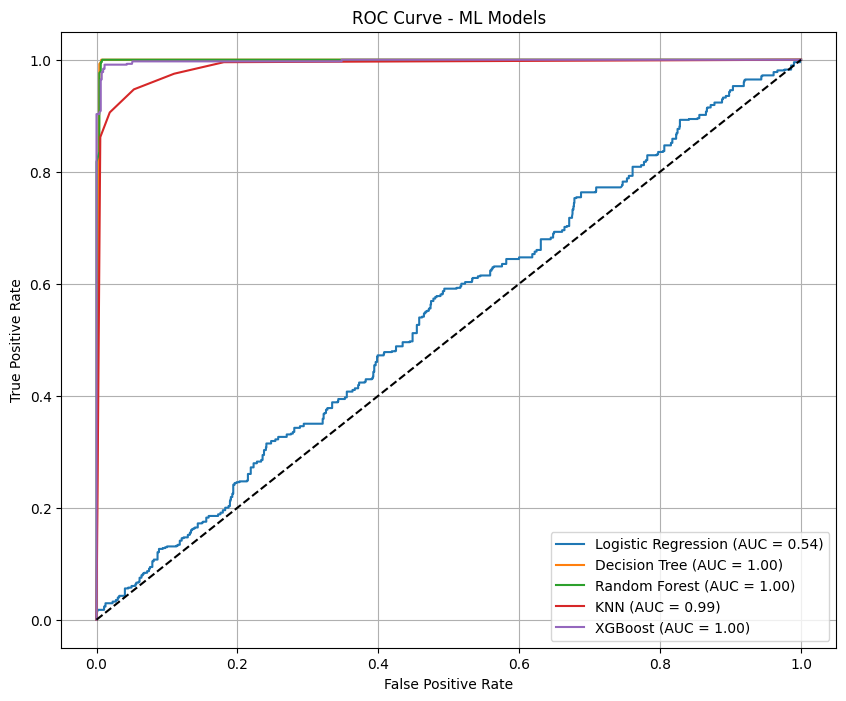

In [29]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ML Models")
plt.legend()
plt.grid()
plt.show()

In [37]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model.summary()
plot_model(nn_model, to_file='neural_network_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [43]:
history = nn_model.fit(
    X_train_bal, y_train_bal,
    epochs=25,  # Or more, depending on convergence
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data for validation
    verbose=1
)

Epoch 1/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7660 - loss: 0.4792 - val_accuracy: 0.7216 - val_loss: 0.5128
Epoch 2/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7616 - loss: 0.4729 - val_accuracy: 0.7187 - val_loss: 0.5023
Epoch 3/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7715 - loss: 0.4717 - val_accuracy: 0.6777 - val_loss: 0.5538
Epoch 4/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7614 - loss: 0.4706 - val_accuracy: 0.6849 - val_loss: 0.5387
Epoch 5/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7642 - loss: 0.4627 - val_accuracy: 0.6978 - val_loss: 0.5343
Epoch 6/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7785 - loss: 0.4510 - val_accuracy: 0.7086 - val_loss: 0.5060
Epoch 7/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7709 - loss: 0.4623 - val_accuracy: 0.6820 - val_loss: 0.5389
Epoch 8/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7892 - loss: 0.4508 - val_accuracy: 0.

In [70]:
X_train_reshaped = X_train.toarray().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.toarray().reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train_reshaped shape:", X_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)

X_train_reshaped shape: (5059, 1, 17)
X_test_reshaped shape: (2169, 1, 17)


In [78]:
# Define the GRU model
def create_gru_model(input_shape):
    model = Sequential([
        GRU(64, activation='relu', input_shape=input_shape),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape_gru = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
gru_model = create_gru_model(input_shape_gru)
gru_model.summary()

c:\Users\Purva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 64)             │        15,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,001 (62.50 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Train the GRU model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Shape of X_train_reshaped before training:", X_train_reshaped.shape)  # ADDED LINE

history_gru = gru_model.fit(
    X_train_reshaped, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Shape of X_train_reshaped before training: (5059, 1, 17)
Epoch 1/20


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7670 - loss: 0.4788 - val_accuracy: 0.7638 - val_loss: 0.5104
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7765 - loss: 0.4725 - val_accuracy: 0.7609 - val_loss: 0.5074
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7744 - loss: 0.4751 - val_accuracy: 0.7431 - val_loss: 0.5065
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7777 - loss: 0.4663 - val_accuracy: 0.7668 - val_loss: 0.5046
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7889 - loss: 0.4641 - val_accuracy: 0.7500 - val_loss: 0.5054
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7719 - loss: 0.4783 - val_accuracy: 0.7520 - val_loss: 0.5023
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7816 - loss: 0.4643 - val_accuracy: 0.7530 - val_loss: 0.5006
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7741 - loss: 0.4683 - val_accuracy: 0.7599 - val_

In [83]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape_lstm = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
lstm_model = create_lstm_model(input_shape_lstm)
lstm_model.summary()

c:\Users\Purva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# Train the LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_lstm = lstm_model.fit(
    X_train_reshaped, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/30


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7024 - loss: 0.5785 - val_accuracy: 0.7125 - val_loss: 0.5725
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6912 - loss: 0.5810 - val_accuracy: 0.7253 - val_loss: 0.5706
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7107 - loss: 0.5756 - val_accuracy: 0.7243 - val_loss: 0.5664
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7247 - loss: 0.5613 - val_accuracy: 0.7233 - val_loss: 0.5660
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7339 - loss: 0.5458 - val_accuracy: 0.7223 - val_loss: 0.5621
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7094 - loss: 0.5583 - val_accuracy: 0.7253 - val_loss: 0.5576
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7126 - loss: 0.5618 - val_accuracy: 0.7273 - val_loss: 0.5560
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7178 - loss: 0.5554 - val_accuracy: 0.7204 - val_